* Writer : Jesoon Kang, Chung-Ang University
* last-modified date : May 20, 2020

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import display, Math, Latex


file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

In [2]:
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

In [3]:
#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)


In [4]:
#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1


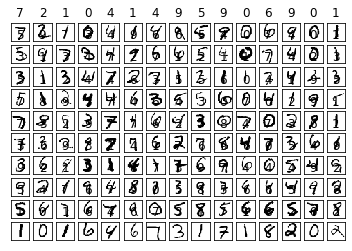

In [5]:
#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

In [33]:
train_data = list_image[:,:6000]
train_label = list_label[:6000]
m = len(train_label)
tmp = np.zeros((10,m))
for i in range(0,m) :
    label = train_label[i]
    tmp[label-1][i] = 1
train_label_vec = tmp

test_data = list_image[:,6000:]
test_label = list_label[6000:]


m = len(test_label)
tmp = np.zeros((10,m))
for i in range(0,m) :
    label = test_label[i]
    tmp[label-1][i] = 1
test_label_vec = tmp



[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [36]:
def forward(data,u,v,w) :
    x_temp = np.ones((image.shape[0]+1, image.shape[1])) # add bia
    x_temp[1:, :] = image
    x = x_temp
    y_ = u.dot(x)
    y = sigmoid_func(y_)

    y_temp = np.ones((y.shape[0] + 1, y.shape[1]))
    y_temp[1:, :] = y
    y = y_temp
    z_ = v.dot(y)
    z = sigmoid_func(z_)

    z_temp = np.ones((z.shape[0] + 1, z.shape[1]))
    z_temp[1:, :] = z
    z = z_temp
    h_ = w.dot(z)
    h = sigmoid_func(h_)

    return x, y, y_, z, z_, h, h_

In [41]:
def sigmoid_grad(z):
    sigmoid =  1.0 / (1.0 + np.exp(-z))
    return sigmoid * (1 - sigmoid)

In [77]:


lr = 1e-4


# the random initial condition is applied to the model parameters following a normal distribution with mean 0 and standard deviation some number
u = np.random.randn(196,785)
v = np.random.randn(49,197)
w = np.random.randn(10,50)

epoch = 0
train_image = list_image[:, :6000]
train_label = list_label[:6000]
test_image = list_image[:,6000:]
test_label = list_label[6000:]

train_label_vec = np.zeros((10, train_label.shape[0]))
for i, val in enumerate(train_label):
    train_label_vec[val, i] = 1.0

list_epoch = []
list_loss_train = []
list_loss_test = []
list_acc_train = []
list_acc_test = []

# Training Start
print("-"*10,"Training Start",'-'*10)

result_train = {}
result_test = {}

while (True) :
    epoch += 1
    
    ## Forward Propagation
    _x = np.ones((train_image.shape[0]+1, train_image.shape[1])) # add bia
    _x[1:, :] = train_image
    x = _x
    
    y_ = u.dot(x)
    y = 1.0/(1.0 + np.exp(-y_))

    _y = np.ones((y.shape[0] + 1, y.shape[1]))
    _y[1:, :] = y
    y = _y
    z_ = v.dot(y)
    z = 1.0/(1.0 + np.exp(-z_))

    _z = np.ones((z.shape[0] + 1, z.shape[1]))
    _z[1:, :] = z
    z = _z
    h_ = w.dot(z)
    h = 1.0/(1.0 + np.exp(-h_))
    loss_train = np.sum(-train_label_vec * (np.log(h)) - (1 - train_label_vec)* np.log(1 - h)) / len(h.T)

    predict = np.argmax(h, axis = 0)
    correct = np.sum(train_label == predict, axis = 0)
    acc_train = correct/len(train_label)

    
    # Back propagation
    d_h = h - train_label_vec
    _z = np.ones((z_.shape[0]+1, z_.shape[1]))
    _z[1:, :] = z_
    z_ = _z
    d_z = w.T.dot(d_h) * sigmoid_grad(z_)
    d_z = d_z[1:, :]

    _y = np.ones((y_.shape[0]+1, y_.shape[1]))
    _y[1:, :] = y_
    y_ = _y
    d_y = v.T.dot(d_z) * sigmoid_grad(y_)
    d_y = d_y[1:, :]

    # Save gradient desent values
    grad_u = d_y.dot(x.T)
    grad_v = d_z.dot(y.T)
    grad_w = d_h.dot(z.T)

    
    ### Testing 
      
    ## Forward Propagation
    _x = np.ones((test_image.shape[0]+1, test_image.shape[1])) # add bia
    _x[1:, :] = test_image
    x = _x
    
    y_ = u.dot(x)
    y = 1.0/(1.0 + np.exp(-y_))

    _y = np.ones((y.shape[0] + 1, y.shape[1]))
    _y[1:, :] = y
    y = _y
    z_ = v.dot(y)
    z = 1.0/(1.0 + np.exp(-z_))

    _z = np.ones((z.shape[0] + 1, z.shape[1]))
    _z[1:, :] = z
    z = _z
    h_ = w.dot(z)
    h = 1.0/(1.0 + np.exp(-h_))
    loss_test = np.sum(-test_label_vec * (np.log(h)) - (1 - test_label_vec)* np.log(1 - h)) / len(h.T)

    predict = np.argmax(h, axis = 0)
    correct = np.sum(test_label == predict, axis = 0)
    acc_test = correct/len(test_label)


    # Update thetas
    u -= lr*grad_u
    v -= lr*grad_v
    w -= lr*grad_w

    list_epoch.append(epoch)
    list_acc_train.append(acc_train)
    list_loss_train.append(loss_train)
    list_acc_test.append(acc_test)
    list_loss_test.append(loss_test)
    
    if epoch % 100 == 0 :
        print("{},{}\n      {},{}".format(list_acc_train[-1],list_loss_train[-1],list_acc_test[-1],list_loss_test[-1]))
    if epoch % 1000 == 0 :
        result_train["epoch"] = list_epoch
        result_train["loss"] = list_loss_train
        result_train["acc"] = list_acc_train
        result_train["theta"] = [u,v,w]
        
        result_test["epoch"] = list_epoch
        result_test["loss"] = list_loss_test
        result_test["acc"] = list_acc_test
        
        
        break

    
   

---------- Training Start ----------
0.68,1.7497931081685003
      0.634,5.458762888629435
0.7871666666666667,1.3030078239497895
      0.736,6.476072343494062
0.8358333333333333,1.0607967056916368
      0.7825,7.241910415111146
0.8676666666666667,0.9008381098429721
      0.8095,7.854917564142285
0.889,0.7830321281645932
      0.82725,8.374167472558748
0.9041666666666667,0.6917672601656268
      0.8395,8.830313988064134
0.9185,0.6181640547485039
      0.845,9.242336821874458
0.9266666666666666,0.5562866308049005
      0.853,9.61956665298886
0.9355,0.5036153464293015
      0.8565,9.965537510924884
0.941,0.4586214357139141
      0.86275,10.287460108306409


# Plot the loss curve

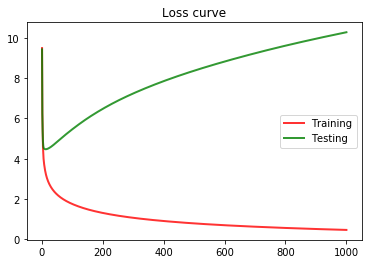

In [78]:
plt.title("Loss curve")
plot_1, = plt.plot(result_train["epoch"],result_train["loss"], color='red',linewidth=2,alpha=0.8)
plot_2, = plt.plot(result_test["epoch"],result_test["loss"], color='green',linewidth=2,alpha=0.8)
plt.legend([plot_1,plot_2],["Training","Testing"])


# Plot the accuracy curve

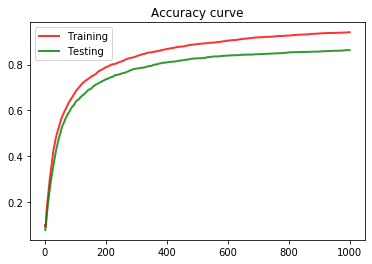

In [80]:
plt.title("Accuracy curve")
plot_1, = plt.plot(result_train["epoch"],result_train["acc"], color='red',linewidth=2,alpha=0.8)
plot_2, = plt.plot(result_test["epoch"],result_test["acc"], color='green',linewidth=2,alpha=0.8)
plt.legend([plot_1,plot_2],["Training","Testing"])


# Plot the accuracy value

In [82]:
print("Final Training Acc : {}\nFinal Testing Acc : {}".format(result_train["acc"][-1],result_test["acc"][-1]))

Final Training Acc : 0.941
Final Testing Acc : 0.86275


In [ ]:
l1_size = 196
l2_size = 49
output_size = 10

data_size = len(train_data)
feature_size = len(train_data.T)

theta_1 = torch.ones([feature_size,l1_size],dtype=torch.double)*0.001
theta_2 = torch.ones((l1_size,l2_size),dtype = torch.double)*0.001
theta_3 = torch.ones((l2_size,output_size), dtype = torch.double)*0.001

b1 = torch.ones((1,l1_size),dtype=torch.double)
b2 = torch.ones((1,l2_size),dtype=torch.double)
b3 = torch.ones((1,output_size),dtype=torch.double)

lr = 0.001

input_data = train_data

while (True) :

    z1 = torch.matmul(input_data,theta_1) + b1
    a1 = 1 / (1 + torch.exp(-y1))
    
    #print(torch.sum(theta_3))
    z2 = torch.matmul(z1,theta_2) + b2
    a2 = 1 / (1+torch.exp(-y2))

    
    z3 = torch.matmul(z2,theta_3) + b3
    a3 = 1 / (1 + torch.exp(-y3))

    L = (1/m)*torch.sum(\
                        -train_label_vec*torch.log(h) - \
                        (1-train_label_vec)*torch.log(1-h)\
                       )
    #############################
    delta3 = a3 - train_label
    
    dL_dt3 = (a3-train_label)*a2
    dL
    
    
    
    
    
    theta_1 -= lr*dL_dt3.T
    theta_2 -= lr*dL_dt2.T
    theta_3 -= lr*dL_dt1.T
    b1 -= lr*d_b_1
    b2 -= lr*d_b_2
    b3 -= lr*d_b_3
    #print(h)
    #rint(predict_result)
    predict_result = torch.argmax(h,1)

    correct_list = predict_result == train_label
    correct = torch.sum(correct_list)
    acc = correct.item() * 1/len(predict_result)
    print("{:.10f}, {:10f}".format(L,acc))




In [ ]:


def update_weights(self,t_y,a_3) :
    error_wb3 = -(torch.div(t_y,a_3+ 0.00011) - torch.div(1.0-t_y,1.0-a_3+ 0.00001)) # sum ep
    d_z_3 = error_wb3*get_derv_activation(self.z_3,self.act_type_3) #         
    d_w_3 = torch.matmul(d_z_3.T,self.a_2)
    d_b_3 = torch.sum(d_z_3, dim=0, keepdim=True) / self.a_2.shape[0] # mean도 됨

    #########

    error_wb2 = torch.matmul(d_z_3,self.w_3)

    d_z_2 = error_wb2*get_derv_activation(self.z_2,self.act_type_2)

    d_w_2 = torch.matmul(d_z_2.T,self.a_1)
    d_b_2 = torch.sum(d_z_2, dim=0,keepdims=True) / self.a_1.shape[0]


    error_wb1 = torch.matmul(d_z_2,self.w_2)
    d_z_1 = error_wb1*get_derv_activation(self.z_1,self.act_type_1)
    d_w_1 = torch.matmul(d_z_1.T,self.t_data_batch)
    d_b_1 = torch.sum(d_z_1, dim=0,keepdims=True) / self.t_data_batch.shape[0]


    self.w_3 += -self.lr*d_w_3
    self.b_3 += -self.lr*d_b_3

    self.w_2 += -self.lr*d_w_2
    self.b_2 += -self.lr*d_b_2
    self.w_1 += -self.lr*d_w_1
    self.b_1 += -self.lr*d_b_1
    #print(b_3,b_2,b_1)

In [ ]:
l1_size = 196
l2_size = 49
output_size = 10

data_size = len(train_data)
feature_size = len(train_data.T)

theta_1 = torch.ones([feature_size+1,l1_size],dtype=torch.double)*0.001
theta_2 = torch.ones((l1_size+1,l2_size),dtype = torch.double)*0.001
theta_3 = torch.ones((l2_size+1,output_size), dtype = torch.double)*0.001

bias_0 = torch.ones((data_size,1),dtype=torch.double)
bias_1 = torch.ones((data_size,1),dtype=torch.double)
bias_2 = torch.ones((data_size,1),dtype=torch.double)

lr = 0.00001


while (True) :

    input_with_bias = torch.cat((train_data,bias_0),1)
    y1 = torch.matmul(input_with_bias,theta_1)
    z1 = 1 / (1 + torch.exp(-y1))
    z1_with_bias = torch.cat((z1,bias_1),1)
    #print(torch.sum(theta_3))
    y2 = torch.matmul(z1_with_bias,theta_2)
    z2 = 1 / (1+torch.exp(-y2))
    z2_with_bias = torch.cat((z2,bias_2),1)

    y3 = torch.matmul(z2_with_bias,theta_3)
    h = 1 / (1 + torch.exp(-y3))

    L = (1/m)*torch.sum(\
                        -train_label_vec*torch.log(h) - \
                        (1-train_label_vec)*torch.log(1-h)\
                       )
    #############################
    error_wb3 = -(torch.div(train_label_vec,h) - torch.div(1-train_label_vec,1-h))
    d_y_3 = error_wb3*h*(1-h)
    d_t_3 = torch.matmul(d_y_3.T,z2_with_bias)

    error_wb2 = torch.matmul(d_y_3,theta_3[:49].T)
    d_y_2 = error_wb2 * z2*(1-z2)
    d_t_2 = torch.matmul(d_y_2.T,z1_with_bias)
    
    error_wb1 = torch.matmul(d_y_2,theta_2[:196].T)
    d_y_1 = error_wb1 * z1*(1-z1)
    d_t_1 = torch.matmul(d_y_1.T,input_with_bias)
    
    theta_1 -= lr*d_t_1.T
    theta_2 -= lr*d_t_2.T
    theta_3 -= lr*d_t_3.T
        

    predict_result = torch.argmax(h,1)

    correct_list = predict_result == train_label
    correct = torch.sum(correct_list)
    acc = correct.item() * 1/len(predict_result)
    print("{:.10f}, {:10f}".format(L,acc))



In [ ]:
l1_size = 196
l2_size = 49
output_size = 10

data_size = len(train_data)
feature_size = len(train_data.T)

theta_1 = torch.ones([feature_size+1,l1_size],dtype=torch.double)*0.1
theta_2 = torch.ones((l1_size+1,l2_size),dtype = torch.double)*0.1
theta_3 = torch.ones((l2_size+1,output_size), dtype = torch.double)*0.1

bias_0 = torch.ones((data_size,1),dtype=torch.double)
bias_1 = torch.ones((data_size,1),dtype=torch.double)
bias_2 = torch.ones((data_size,1),dtype=torch.double)

lr = 0.00001


while (True) :

    input_with_bias = torch.cat((train_data,bias_0),1)
    y1 = torch.matmul(input_with_bias,theta_1)
    z1 = 1 / (1 + torch.exp(-y1))
    z1_with_bias = torch.cat((z1,bias_1),1)
    #print(torch.sum(theta_3))
    y2 = torch.matmul(z1_with_bias,theta_2)
    z2 = 1 / (1+torch.exp(-y2))
    z2_with_bias = torch.cat((z2,bias_2),1)

    y3 = torch.matmul(z2_with_bias,theta_3)
    h = 1 / (1 + torch.exp(-y3))

    L = (1/m)*torch.sum(\
                        -train_label_vec*torch.log(h) - \
                        (1-train_label_vec)*torch.log(1-h)\
                       )
    #############################
    dL_dh_dh_dy3 = h-train_label_vec
    dy3_dt3 = z2_with_bias

    dL_t3 = torch.matmul(dy3_dt3.T,dL_dh_dh_dy3)
    theta_3 -= lr*dL_t3

    test = torch.matmul(theta_3[:49],dL_dh_dh_dy3.T)
    test = test.T*(z2*(1-z2))
    dL_dh_dh_dy3_dy3_dz2_dz2_dy2 = test
    test = torch.matmul(z1_with_bias.T,test)
    dL_t2 = test
    theta_2 -= lr*dL_t2

    test = torch.matmul(theta_2[:196],dL_dh_dh_dy3_dy3_dz2_dz2_dy2.T)
    test = test.T*(z1*(1-z1))
    test = torch.matmul(input_with_bias.T,test)
    dL_t1 = test
    theta_1 -= lr*dL_t1


    predict_result = torch.argmax(h,1)

    correct_list = predict_result == train_label
    correct = torch.sum(correct_list)
    acc = correct.item() * 1/len(predict_result)
    print("{:.10f}, {:10f}".format(L,acc))

In [ ]:
l1_size = 196
l2_size = 49
output_size = 10

data_size = len(train_data)
feature_size = len(train_data.T)

theta_1 = torch.ones([feature_size+1,l1_size],dtype=torch.double)*0.1
theta_2 = torch.ones((l1_size+1,l2_size),dtype = torch.double)*0.1
theta_3 = torch.ones((l2_size+1,output_size), dtype = torch.double)*0.1

bias_0 = torch.ones((data_size,1),dtype=torch.double)
bias_1 = torch.ones((data_size,1),dtype=torch.double)
bias_2 = torch.ones((data_size,1),dtype=torch.double)

lr = 0.001
## Loop

input_with_bias = torch.cat((train_data,bias_0),1)
y1 = torch.matmul(input_with_bias,theta_1)
z1 = 1 / (1 + torch.exp(-y1))
z1_with_bias = torch.cat((z1,bias_1),1)

y2 = torch.matmul(z1_with_bias,theta_2)
z2 = 1 / (1+torch.exp(-y2))
z2_with_bias = torch.cat((z2,bias_2),1)

y3 = torch.matmul(z2_with_bias,theta_3)
h = 1 / (1 + torch.exp(-output_layer))

L = (1/m)*torch.sum(\
                    -train_label_vec*torch.log(act_output_layer) - \
                    (1-train_label_vec)*torch.log(1-act_output_layer)\
                   )
        

In [ ]:
dL_dh_dh_dy3 = act_output_layer-train_label_vec
dy3_dt3 = z2_with_bias

print(dL_dh_dh_dy3.shape)
print(dy3_dt3.shape)
dL_t3 = torch.matmul(dy3_dt3.T,dL_dh_dh_dy3)
theta_3 -= lr*dL_t3


In [ ]:
print(dL_dh_dh_dy3.shape)
print(theta_3[:49].shape)
print((z2*(1-z2)).shape)
print(z1_with_bias.shape)


test = torch.matmul(theta_3[:49],dL_dh_dh_dy3.T)
print("test")
print(test.shape)
print((z2*(1-z2)).shape)
test = test.T*(z2*(1-z2))
dL_dh_dh_dy3_dy3_dz2_dz2_dy2 = test
print(test.shape)
test = torch.matmul(z1_with_bias.T,test)
dL_t2 = test
theta_2 -= lr*dL_t2

In [ ]:
test = torch.matmul(theta_2[:196],dL_dh_dh_dy3_dy3_dz2_dz2_dy2.T)
test = test.T*(z1*(1-z1))
test = torch.matmul(input_with_bias.T,test)
print(test.shape)
theta_1 -= lr*theta_1

In [ ]:
print(h.shape)

predict_result = torch.argmax(h,1)

correct_list = predict_result == train_label
correct = torch.sum(correct_list)
acc = correct.item() * 1/len(predict_result)
print(acc)


In [ ]:
#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()

In [ ]:
#
# make a matrix each column of which represents an images in a vector form 
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)
count = 0

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])

    list_label[count]       = label
    list_image[:, count]    = im_vector    
    
    count += 1
    
avg_imgs = {}

In [ ]:
# Calculate the Average Image for Each Digit
for i in range(0,10) :
    list_label_image = list_image[:,list_label == i]
    m = list_label_image.shape[1]
    avg_image = list_label_image.mean(axis=1)
    avg_imgs[i] = avg_image.reshape((size_row, size_col))

* Assign random values from the normal distribution $\mathcal{N}(0, 1)$ with mean 0 and standard deviation 1 to the weights of the fully connected layer using a logistic unit without a bias

In [ ]:
size_layer_1 = 10
thetas_to_layer_1 = torch.DoubleTensor(size_row*size_col,size_layer_1).normal_(0,1)

* Compute the forward propagation and take the average of the output values for the images of the same label

In [ ]:
avg_outputs = {}
for i in range(0,10) :
    
    list_label_vector = list_image[:,list_label==i]
    m = list_label_vector.shape[1]

    data = torch.DoubleTensor(list_label_vector).T
    y_layer_1 = torch.matmul(data,thetas_to_layer_1)
    z_output = 1 /  (1+torch.exp(-y_layer_1))

    avg_outputs[i] = z_output.mean()

# Plot the average image

* Plot the average images of the same label for each digit
* Arrange the subplots in 2x5 array for the 10 average images and present the label at the title of each subplot in the increasing order of the label

In [ ]:
# Plot the Average Image for Each Digit
for i in range(0,10) :
    im_matrix = avg_imgs[i]
    plt.subplot(2,5,i+1)
    plt.title(i)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

# Present the output of the neural network with random weights

* Present the average values for each label in the increasing order of the label

In [ ]:
for i in range(0,10) :
    print("Average Output on label {:d} : {:.5f}".format(i,avg_outputs[i]))